# AWS

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator
import random,os,glob
import matplotlib.pyplot as plt
import zipfile as zf

## Dataset Input

The datset used in this notebook is :
https://drive.google.com/file/d/1IXhP2OFvUaRieTkmbrdtlzHSDiiQqvHI/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip -uq "/content/drive/MyDrive/dataset-summer-school-cnn.zip"

In [ ]:
files = zf.ZipFile("/home/invisibleam/Documents/dataset-summer-school-cnn.zip",'r')
file2=files.extractall()
files.close()


In [ ]:
dir_path = 'dataset-resized/train'

In [ ]:
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))

In [ ]:
len(img_list)

2091

# Image Augmentation

## ImaheDataGenerator


In [ ]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 1884 images belonging to 6 classes.
Found 207 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


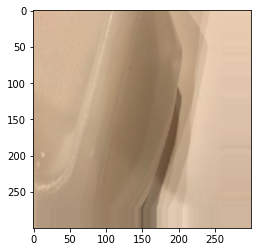

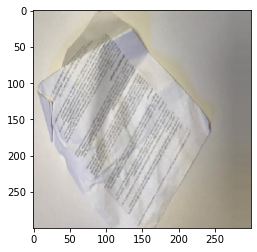

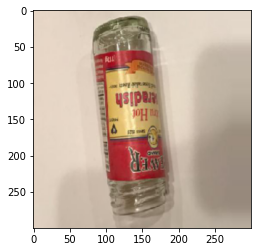

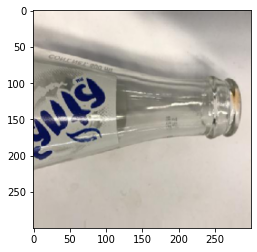

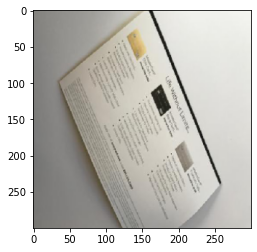

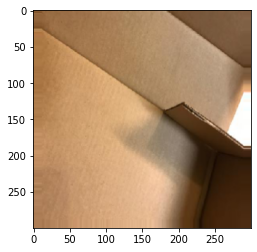

In [ ]:
from keras.preprocessing import image

x,y = train_generator.next()
for i in range(0,6):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

### Writing the labels file

In [ ]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


# Building CNN & Saving keras model

In [ ]:
model=Sequential()


model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(128,(3,3), padding='same',activation='relu'))
model.add(Conv2D(128,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2))


model.add(Flatten())

model.add(Dense(256,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]




[Callback model Checkpoint Reference](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

# Summarizing our model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 150, 128)     36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 128)      0         
 2D)                                                    

### Compiling Model using categorical cross entropy loss function & Adam Optimizer

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['acc'])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Let's Train

In [ ]:
history = model.fit(train_generator,
                              epochs=10,
                              steps_per_epoch=1884//32,
                              validation_data=test_generator,
                              validation_steps=207//32,

                              callbacks=callbacks_list)


Epoch 1/10
58/58 [==============================] - ETA: 0s - loss: 0.4794 - acc: 0.8342
Epoch 1: val_acc did not improve from 0.78646
58/58 [==============================] - 45s 754ms/step - loss: 0.4794 - acc: 0.8342 - val_loss: 0.7332 - val_acc: 0.7812
Epoch 2/10
58/58 [==============================] - ETA: 0s - loss: 0.4036 - acc: 0.8612
Epoch 2: val_acc did not improve from 0.78646
58/58 [==============================] - 43s 742ms/step - loss: 0.4036 - acc: 0.8612 - val_loss: 1.0371 - val_acc: 0.7552
Epoch 3/10
58/58 [==============================] - ETA: 0s - loss: 0.4228 - acc: 0.8548
Epoch 3: val_acc improved from 0.78646 to 0.79688, saving model to trained_model.h5
58/58 [==============================] - 44s 748ms/step - loss: 0.4228 - acc: 0.8548 - val_loss: 0.7592 - val_acc: 0.7969
Epoch 4/10
58/58 [==============================] - ETA: 0s - loss: 0.4054 - acc: 0.8602
Epoch 4: val_acc improved from 0.79688 to 0.80208, saving model to trained_model.h5
58/58 [===========

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


model = load_model('/content/trained_model.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 150, 128)     36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 128)      0         
 2D)                                                    

In [ ]:
model.evaluate(test_generator)

7/7 [==============================] - 1s 142ms/step - loss: 0.8540 - acc: 0.7971


[0.8540299534797668, 0.7971014380455017]

# Accuracy Graph

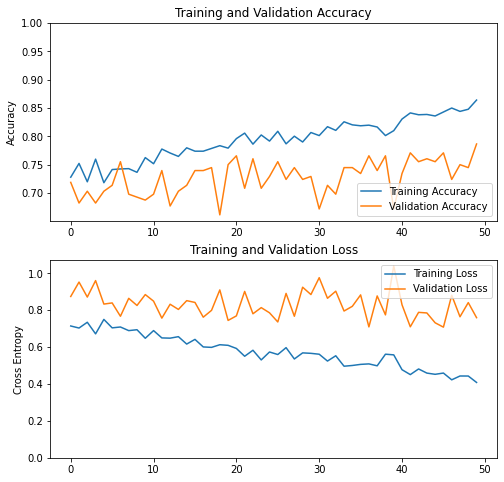

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# Testing PREDICTION


Classified: cardboard
confidence :  99.99722242355347


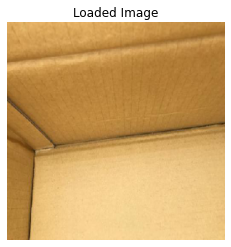

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = 'dataset-resized/preds/cardboard343.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img)

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)

predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)
print("confidence : ",100 * np.max(p))





In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


model = load_model('trained_model.h5')

predpath = 'dataset-resized/preds'

imglist=[]
plist=[]
for img_path in os.listdir(predpath):

    img = tf.keras.utils.load_img('dataset-resized/preds/'+img_path, target_size=(300, 300))
    img = image.img_to_array(img, dtype=np.uint8)
    img=np.array(img)/255.0
    p=model.predict(img[np.newaxis, ...])
    imglist.append(img)
    plist.append(p)







In [ ]:
print(len(imglist))


43


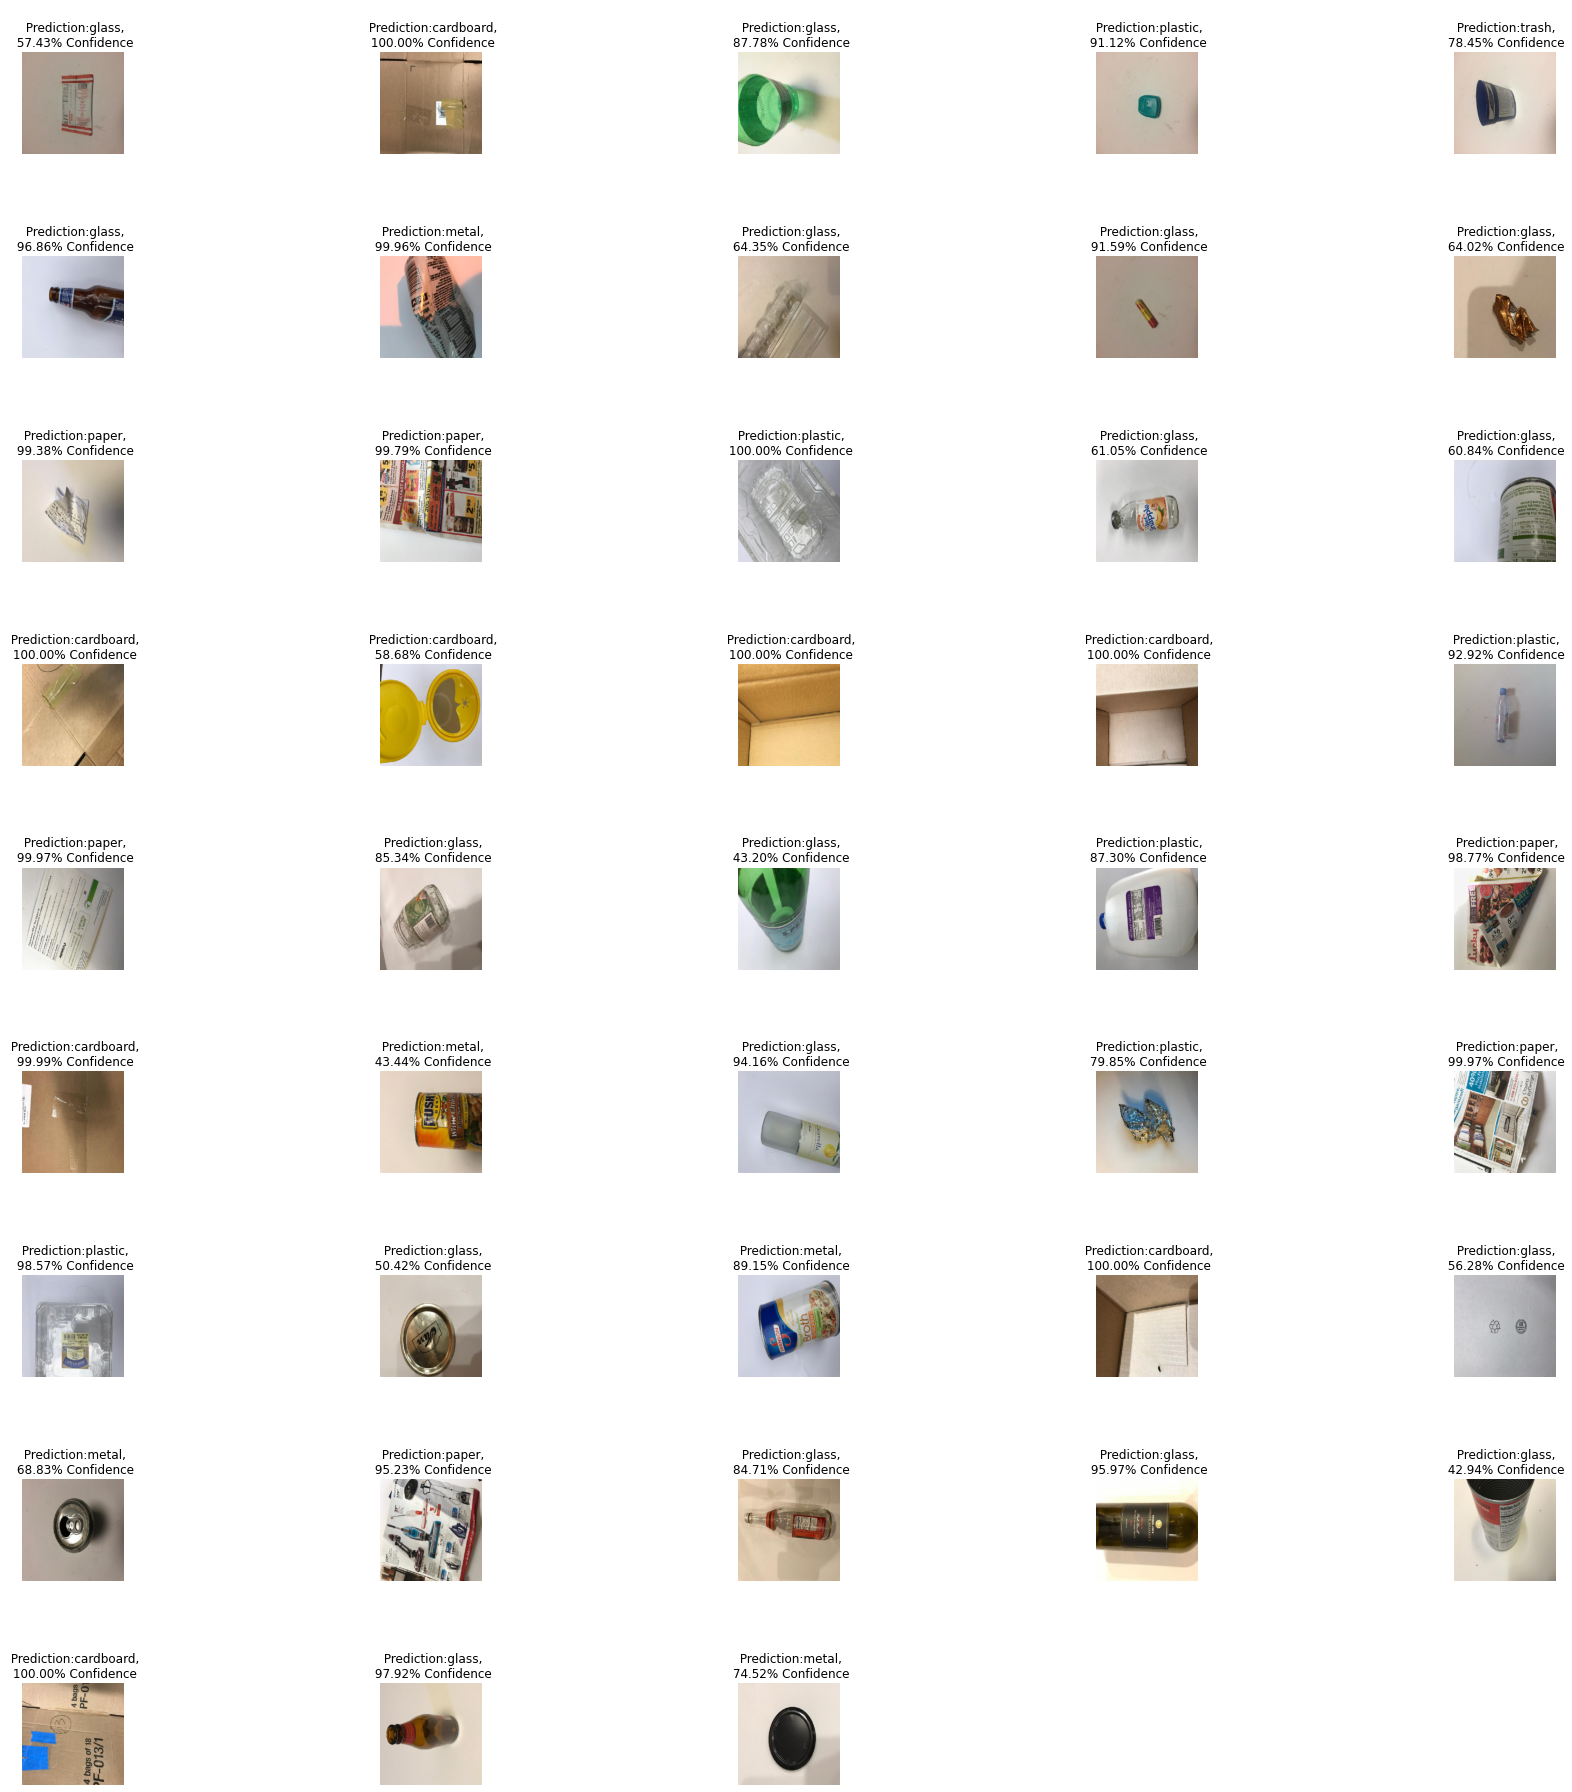

In [ ]:

plt.figure(figsize=(25, 25))
for i in range(len(imglist)):
    plt.subplot(9,5,i+1)
    plt.imshow(imglist[i])
    plt.title('\n Prediction:{},\n {:.2f}% Confidence'
              .format(labels[np.argmax(plist[i])], 100 * np.max(plist[i])))


    plt.axis("off")
plt.tight_layout()
plt.subplots_adjust( hspace=1)
plt.show()